In [36]:
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [37]:
# Read recipe inputs
census_income_clean = dataiku.Dataset("census_income_clean")
census_df = census_income_clean.get_dataframe()

### Data Cleaning & Preprocessing

In [38]:
census_df

,age,class_of_worker,education,wage_per_hour,edu_inst_last_wk,marital_status,industry,occupation,race,hispanic_origin,sex,member_labor_union,unemployment_reason,employment_status,capital_gains,capital_losses,dividends_from_stocks,tax_filer_status,previous_residence_region,previous_residence_state,household_family_status,household_summary,instance_weight,change_in_msa,change_in_reg,move_within_reg,live_in_this_house_1_year_ago,prev_res_in_sunbelt,num_employed_by_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,target_column,dataset
0,73,Not in universe,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,train
1,58,Self-employed-not incorporated,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0,train
2,18,Not in universe,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0,train
3,9,Not in universe,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,train
4,10,Not in universe,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,train
5,48,Private,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,Amer Indian Aleut or Eskimo,All other,Female,No,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,162.61,?,?,?,Not in universe under 1 year old,?,1,Not in universe,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,0,train
6,42,Private,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,5178,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,1535.86,Nonmover,Nonmover,Nonmover,Yes,Not in universe,6,Not in universe,United-States,United-States,

In [39]:
train = census_df[census_df['dataset'] == 'train']
test = census_df[census_df['dataset'] == 'test']

In [40]:
# Check cardinality of each column to determine whether they need to be reduced
for col in census_df.columns:
    if census_df[col].dtype == "object":
        print("Cardinality of " + col + ":", census_df[col].nunique())

Cardinality of class_of_worker: 9
Cardinality of education: 17
Cardinality of edu_inst_last_wk: 3
Cardinality of marital_status: 7
Cardinality of industry: 24
Cardinality of occupation: 15
Cardinality of race: 5
Cardinality of hispanic_origin: 9
Cardinality of sex: 2
Cardinality of member_labor_union: 3
Cardinality of unemployment_reason: 6
Cardinality of employment_status: 8
Cardinality of tax_filer_status: 6
Cardinality of previous_residence_region: 6
Cardinality of previous_residence_state: 51
Cardinality of household_family_status: 38
Cardinality of household_summary: 8
Cardinality of change_in_msa: 10
Cardinality of change_in_reg: 9
Cardinality of move_within_reg: 10
Cardinality of live_in_this_house_1_year_ago: 3
Cardinality of prev_res_in_sunbelt: 4
Cardinality of family_members_under_18: 5
Cardinality of country_of_birth_father: 43
Cardinality of country_of_birth_mother: 43
Cardinality of country_of_birth_self: 43
Cardinality of citizenship: 5
Cardinality of fill_inc_questionna

In [41]:
# Trim categories of education to reduce features of one-hot encoding
def group_education(x):

    edu_dict = {'Children'                               : 'Child',
                'Less than 1st grade'                    : 'None',
                '1st 2nd 3rd or 4th grade'               : 'Some primary',
                'High school graduate'                   : 'High school graduate',
                'Some college but no degree'             : 'Some college',
                'Bachelors degree(BA AB BS)'             : 'Bachelors',
                'Masters degree(MA MS MEng MEd MSW MBA)' : 'Masters',
                'Prof school degree (MD DDS DVM LLB JD)' : 'Professional',
                'Doctorate degree(PhD EdD)'              : 'Doctorate'}

    some_middle_school = ['5th or 6th grade', '7th and 8th grade']
    some_high_school = ['9th grade', '10th grade', '11th grade', '12th grade no diploma']
    associates = ['Associates degree-academic program', 'Associates degree-occup /vocational']


    if x in some_middle_school:
        return 'Some middle school'
    elif x in some_high_school:
        return 'Some high school'
    elif x in associates:
        return 'Associates'
    else:
        return edu_dict[x]
census_df['education'] = census_df['education'].apply(lambda x: group_education(x))

In [42]:
# Trim regions of birth/citizenship country to reduce features of one-hot encoding
def group_country(x):

    eastern_europe  = ['Hungary', 'Yugoslavia', 'Poland']
    western_europe  = ['France', 'Germany', 'Holand-Netherlands']
    united_kingdom  = ['England', 'Scotland', 'Ireland']
    south_america   = ['Ecuador', 'Nicaragua', 'Peru', 'Columbia']
    central_america = ['Guatemala', 'Panama', 'El-Salvador', 'Honduras']
    caribbean       = ['Haiti', 'Dominican-Republic', 'Cuba', 'Jamaica', 'Trinadad&Tobago']
    southeast_asia  = ['Laos', 'Cambodia', 'Thailand', 'Vietnam', 'Philippines']
    east_asia       = ['Taiwan', 'China', 'Hong Kong', 'South Korea', 'Japan']
    us_territory    = ['Puerto-Rico', 'Outlying-U S (Guam USVI etc)']

    if x in eastern_europe:
        return 'Eastern Europe'
    elif x in western_europe:
        return 'Western Europe'
    elif x in united_kingdom:
        return 'UK'
    elif x in south_america:
        return 'South America'
    elif x in central_america:
        return 'Central America'
    elif x in caribbean:
        return 'Caribbean'
    elif x in southeast_asia:
        return 'Southeast Asia'
    elif x in east_asia:
        return 'East Asia'
    elif x in us_territory:
        return 'US Territory'
    else:
        return x

def group_citizen(x):
    if x == 'Native- Born in the United States':
        return 'United States'
    elif x == 'Foreign born- Not a citizen of U S':
        return 'Foreign'
    else:
        return 'Naturalized/Abroad US'

census_df['country_of_birth_father'] = census_df['country_of_birth_father'].apply(lambda x: group_country(x))
census_df['country_of_birth_mother'] = census_df['country_of_birth_mother'].apply(lambda x: group_country(x))
census_df['country_of_birth_self']   = census_df['country_of_birth_self'].apply(lambda x: group_country(x))
census_df['citizenship']             = census_df['citizenship'].apply(lambda x: group_citizen(x))

In [43]:
# drop redundant columns
drop_cat_cols = ['previous_residence_state', 'household_family_status', 'move_within_reg', 'prev_res_in_sunbelt']
census_df = census_df.drop(drop_cat_cols, axis=1)

### Data Analysis

Here we examine the correlation matrix for the numerical and categorical features. We analyze trends further by plotting data using the Charts feature (see PPT). NOTE: WE ONLY PLOT TrAINING DATA SO AS NOT TO GAIN KNOWLEDGE ABOUT THE TEST SET. Source for heat map code: https://towardsdatascience.com/machine-learning-on-categorical-variables-3b76ffe4a7cb

In [44]:
corr_df = census_df[census_df['dataset'] == 'train'].drop('dataset', axis=1)

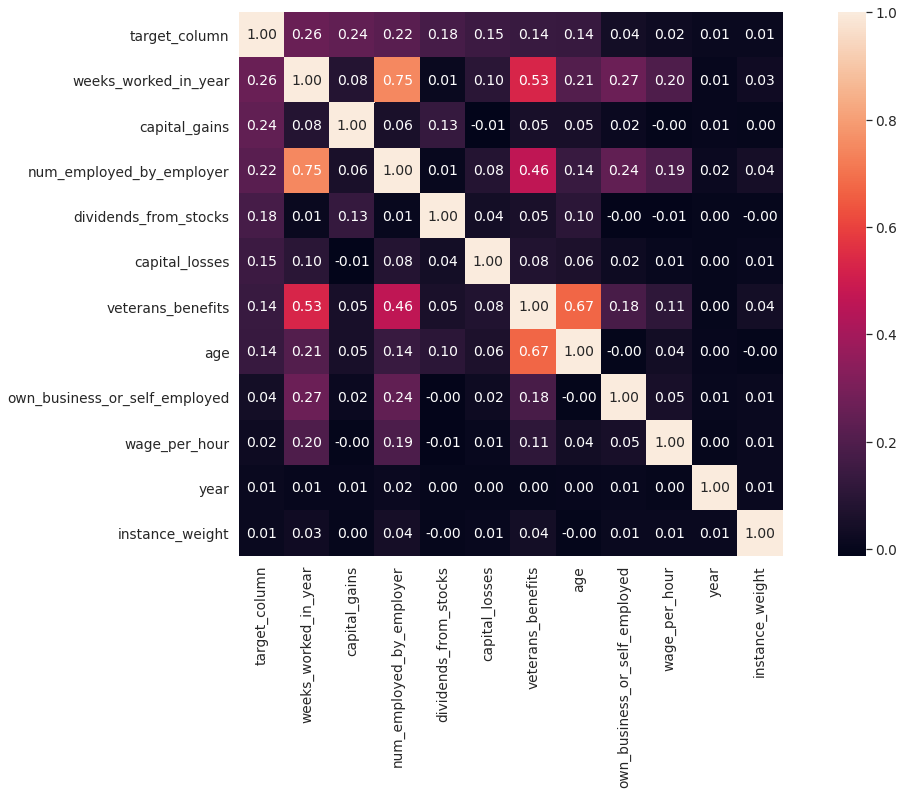

In [45]:
# correlations of numerical variables
corrmat = corr_df.corr()
plt.figure(figsize=(20,10))
cols = corrmat.nlargest(len(corrmat.columns), 'target_column')['target_column'].index
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat[cols].loc[cols], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

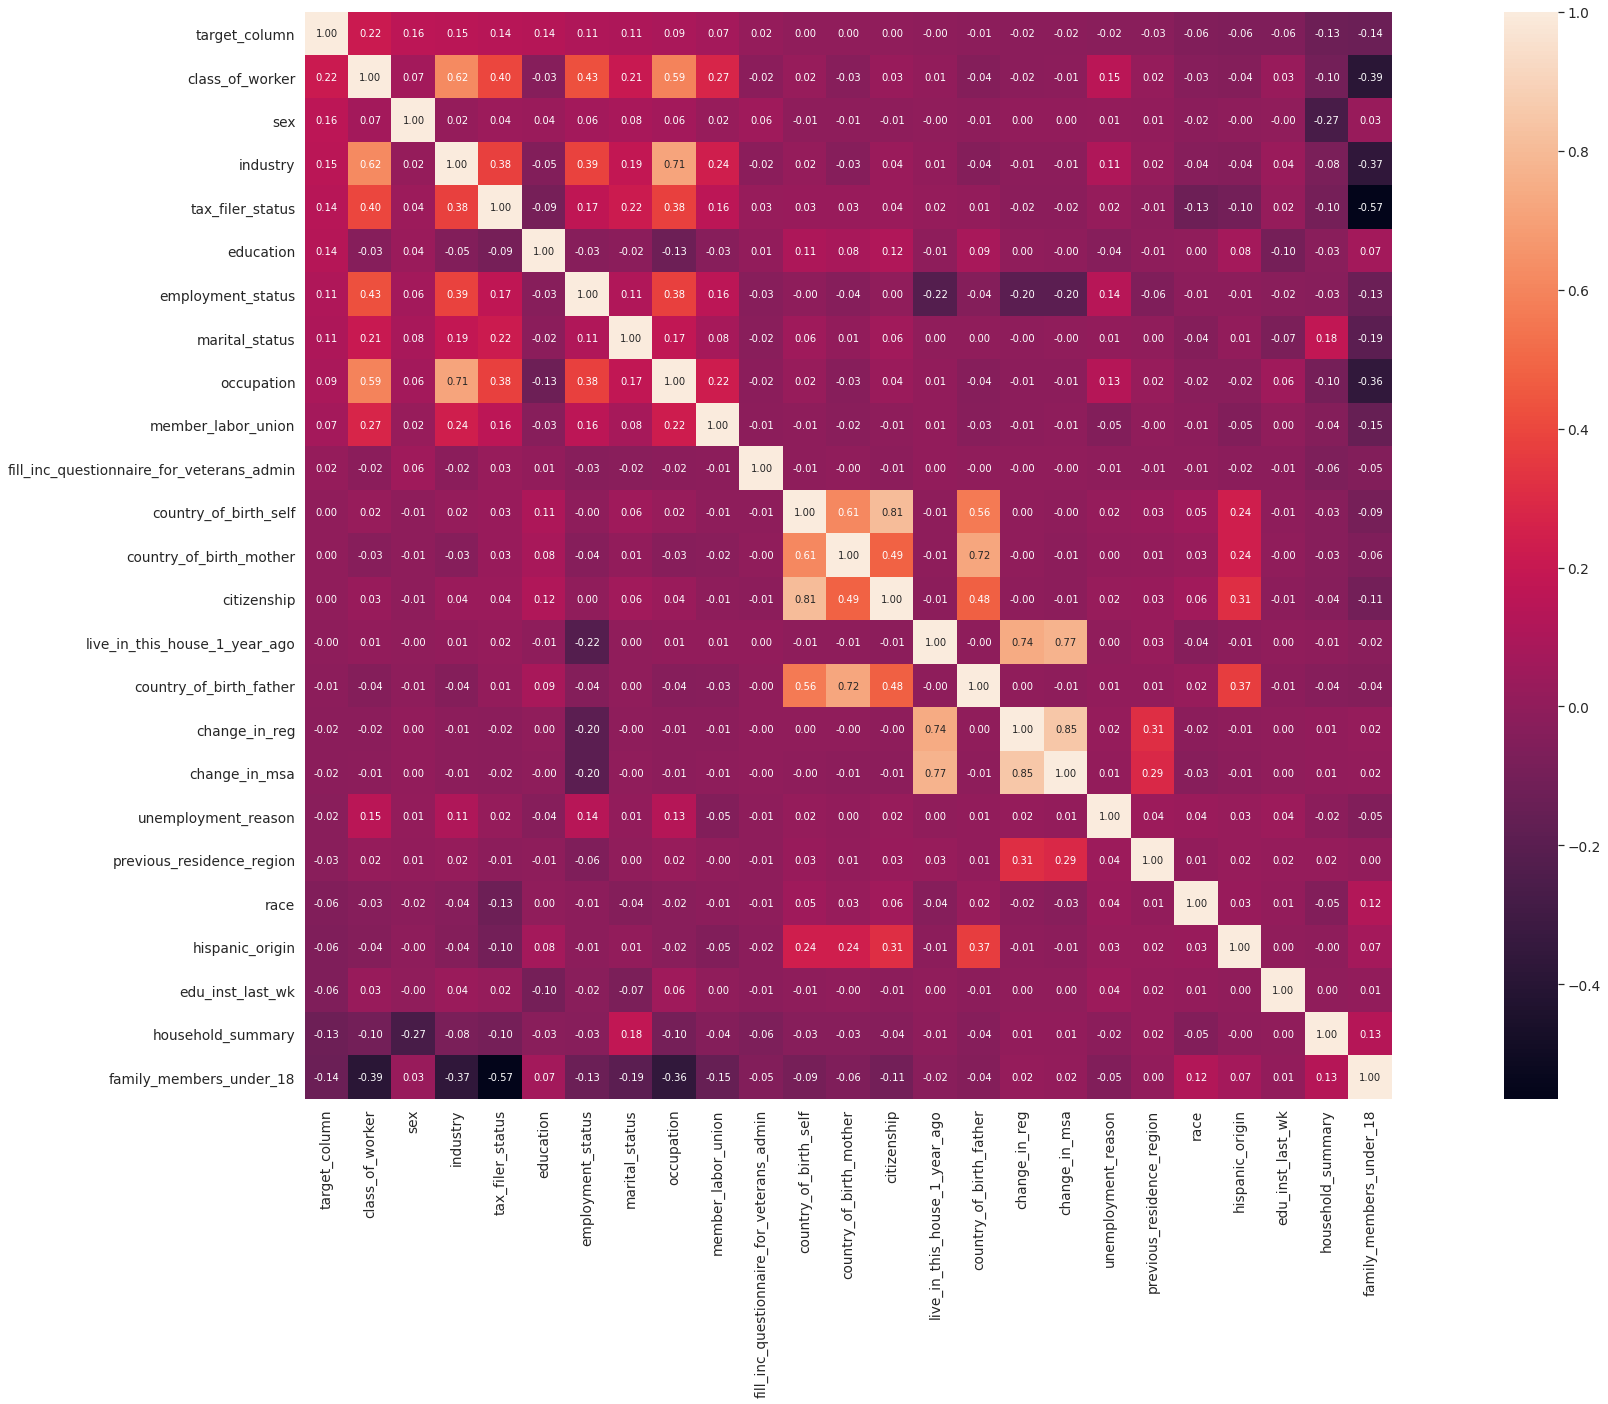

In [46]:
# Show all 33 categorical features (for analysis)
corr_df_cat = corr_df[[x for x in corr_df.columns if x not in corrmat.index] + ['target_column']]
corrmat_cat = corr_df_cat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.figure(figsize=(40,20))
k = 33
cols = corrmat_cat.nlargest(k, 'target_column')['target_column'].index
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat_cat[cols].loc[cols], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

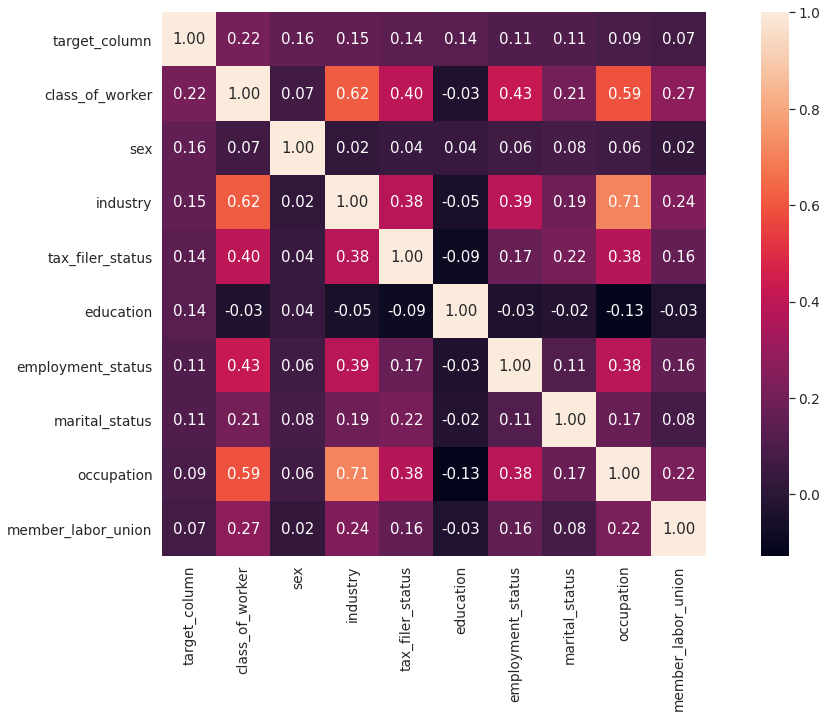

In [47]:
# Show top 10 categorical features only
corr_df_cat = corr_df[[x for x in corr_df.columns if x not in corrmat.index] + ['target_column']]
corrmat_cat = corr_df_cat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.figure(figsize=(20,10))
k = 10
cols = corrmat_cat.nlargest(k, 'target_column')['target_column'].index
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat_cat[cols].loc[cols], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature Engineering

In [48]:
# adjust binary categorical columns so they do not get one-hot encoding
census_df['male'] = census_df['sex'].apply(lambda x : 1 if x=='Male' else 0)
census_df['fill_veterans_q'] = census_df['fill_inc_questionnaire_for_veterans_admin'].apply(lambda x : 1 if x == 'Yes' else 0)
census_df['hispanic_origin'] = census_df['hispanic_origin'].apply(lambda x : 0 if (x == 'All other' or x == 'Do no know') else 1)
census_df['year_since_94'] = census_df['year'].apply(lambda x : x - 94)
census_df = census_df.drop(['sex', 'fill_inc_questionnaire_for_veterans_admin', 'year'], axis=1)

In [49]:
census_df['own_business_or_self_employed'] = census_df['own_business_or_self_employed'].astype('category')
census_df['veterans_benefits'] = census_df['veterans_benefits'].astype('category')
for i in census_df.select_dtypes(include='object').columns:
    census_df[i] = census_df[i].astype('category')

In [50]:
X_label = census_df[['target_column', 'dataset']]
X_num = census_df.select_dtypes(exclude=['category']).drop('target_column', axis=1)
X_cat = census_df.select_dtypes(include=['category']).drop('dataset', axis=1)

In [51]:
# one-hot encoding of categorical features
X_encoded = pd.get_dummies(X_cat)

In [52]:
frames = [X_encoded, X_num, X_label]
X_features = pd.concat(frames, axis=1)
X_features.shape

(299285, 216)

In [53]:
train = X_features[X_features['dataset'] == 'train'].drop('dataset', axis=1)
test = X_features[X_features['dataset'] == 'test'].drop('dataset', axis=1)

In [54]:
# Write recipe outputs
census_income_features_train = dataiku.Dataset("census_income_features_train")
census_income_features_train.write_with_schema(train)
census_income_features_test = dataiku.Dataset("census_income_features_test")
census_income_features_test.write_with_schema(test)
census_income_features_viz = dataiku.Dataset("census_income_features_viz")
census_income_features_viz.write_with_schema(census_df)

199523 rows successfully written (jK4m3dIp6b)
99762 rows successfully written (1vH7jvoGND)
299285 rows successfully written (lAu1ZZaylV)
